# AIM gist in Python

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot')
#[u'dark_background', u'bmh', u'grayscale', u'ggplot', u'fivethirtyeight']

# Enable inline plotting
%matplotlib inline

# These are the "Tableau 20" colors as RGB.  
tableau20 = [(31, 119, 180), (255, 127, 14),  
             (44, 160, 44), (214, 39, 40),  
             (148, 103, 189), (140, 86, 75),  
             (227, 119, 194), (127, 127, 127),  
             (188, 189, 34), (23, 190, 207)] 

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.  
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.) 


###############################################################################
# Define our doublewell potential function, the function to integrate.
# Treat du as a boolean.  1 for the derivative 0 otherwise.
###############################################################################

def doubleWellPot(x, du):
    x2 = x*x                #x^2
    x3 = x2*x               #x^3
    x4 = x2*x2              #x^4
    #The function of a symetric double well is -a*x^2 + b*x^4
    a = 5.0                 # Change the value of a 0.5
    b = a/2                 # Change the value of b 0.25
    if du == 0:
        return -a*x2 + b*x4     # Return the value of our potential
    else:
        return -2*a*x + 4*b*x3  # Return the derivative

###############################################################################
# Define lennard jones potential and derivative
###############################################################################

def lj(r):
    if not hasattr(r, "__len__"):
        if r == 0:
            return 0
    r = 1.0/r
    return 4.0*(r**12.0 - r**6.0)

def ljDeriv(r):
    if not hasattr(r, "__len__"):
        if r == 0:
            return 0
    #r = 1.0/r
    return 24.0*(r**(-7.0) - 2*r**(-13.0))


###############################################################################
# Setup the constants
###############################################################################

# Number of steps
nSteps = int(1000000)
# Maximum change in r
maxDr = float(0.5)
# 1/(temp*gasconstant)
T = 0.2
beta = float(1.0/T)
# Size of the box for periodic boundary conditions
L = float(3.0)
# Maximum interaction distance
rc = 3.0
# x, y position of particle one
One = np.array([float(np.random.uniform(0,1)), float(np.random.uniform(0,1))])
# x, y position of particle two
Two = np.array([float(np.random.uniform(0,1)), float(np.random.uniform(0,1))])
# Distance between x and y positions of the particles
dr = Two - One
# Total distance between the particles
rCurrent = np.sqrt(dr[0]**2 + dr[1]**2)
# Current energy between the particles
uCurrent = lj(rCurrent)
# Track the MC acceptance rate
acc = int(0)
# Track the AIM acceptance rate
l_accept = int(0)
# nbins is the number of windows/segments used in AIM
nbins = int(200)
# Range of relevent areas of the potential
rng=[1.0, rc]
# all possible values of the distance between the particles
l_values = np.linspace(rng[0],rng[1],nbins)
# Indexes for lambda values
l_current = int(0)
l_trial = int(0)
# Storage for lambda values
l_old = float(0.0)
l_new = float(0.0)
# Our step size
lstep = 1.0/float(nbins)
# Initialize the arrays for storage of the AIM values
dfest = np.zeros(nbins)
dfnum = np.zeros(nbins)
dfsum = np.zeros(nbins)
dfpmf = np.zeros(nbins)

# Our bin size
binsize = nbins  
bins = np.linspace(rng[0],rng[1],nbins+1)
n = 0


In [ ]:
###############################################################################
# The main loop
###############################################################################
while n < nSteps:
    # Generate a random number between 0 and 1
    # if it is less than 0.5 then the trial particle is particle
    # one otherwise the trial particle is particle two.
    if np.random.uniform(0,1) <= 0.5:
        xTrial = One[0] + maxDr*(np.random.uniform(0,1)-0.5)
        yTrial = One[1] + maxDr*(np.random.uniform(0,1)-0.5)
        OneTrial = np.array([xTrial, yTrial])
        TwoTrial = Two
    else:
        xTrial = Two[0] + maxDr*(np.random.uniform(0,1)-0.5)
        yTrial = Two[1] + maxDr*(np.random.uniform(0,1)-0.5)
        TwoTrial = np.array([xTrial, yTrial])
        OneTrial = One   
    # Apply Zero Flux Boundary Conditions to reject a move outside of the box
    if (xTrial > L) or (xTrial < 0):
        continue
    elif (yTrial > L) or (yTrial < 0):
        continue
    else:
        # Calculate the distance between X and Y
        drTrial = TwoTrial - OneTrial
        rTrial = np.sqrt(drTrial[0]**2 + drTrial[1]**2)
        # Calculate the potential energy
        uTrial = lj(rTrial)
        # Calculate the difference in potential energy
        deltaU = uTrial - uCurrent
        # If the proposed energy is lower then we accept
        if deltaU < 0:
            One = OneTrial
            Two = TwoTrial
            rCurrent = rTrial
            uCurrent = uTrial
            acc += 1
        # If the proposed energy is higher accept only with probability exp()
        elif np.random.uniform(0,1) < np.exp(-deltaU*beta):
            One = OneTrial
            Two = TwoTrial
            rCurrent = rTrial
            uCurrent = uTrial
            acc += 1  
    
##########################################################################
#   AIM 
##########################################################################

    # Randomly choose a direction in the index
    if np.random.uniform(0,1) < 0.5:
        l_trial = l_current + 1
    else:
        l_trial = l_current - 1
        
    laccept = -1    
    
    # Track the value of l_trial so we are within the possible values    
    if l_trial < 0:
        laccept = 0
    if l_trial > (nbins-1):
        laccept = 0
        
    # Now we take our trial move
    if laccept < 0: 
        # lambda old is the old configuration of the system
        l_old = l_values[l_current]
        # lambda_new is the new configuration of the system
        l_new = l_values[l_trial]
        # Calculate the potential energy at the proposed position
        uOld = lj(l_old)
        uNew = lj(l_new)
        # Get the energy difference
        du = uNew - uOld
        # Trapezoidal rule integrate from l_current to l_trial
        df = 0.5*(l_new-l_old)*(dfest[l_trial]+dfest[l_current])
        mcprobe = np.exp(-beta*(du-df))
        # If uLamdaTrial is less than probability, then accept
        if mcprobe >= np.random.uniform(0,1): 
            laccept = 1
        else:
            laccept = 0
    # Update values
    if laccept > 0:
        l_accept += 1
        l_current = l_trial
        rCurrent = l_new
        uCurrent = uNew
        
    # Update Free energy estimates    
    dfnum[l_current] += 1.0
    dfsum[l_current] += ljDeriv(l_values[l_current])
    dfest[l_current] = float(dfsum[l_current])/float(dfnum[l_current])
    n += 1

('Boltzman PMF: ', -43.070714796565397)
('AIM PMF: ', -43.81404740125982)


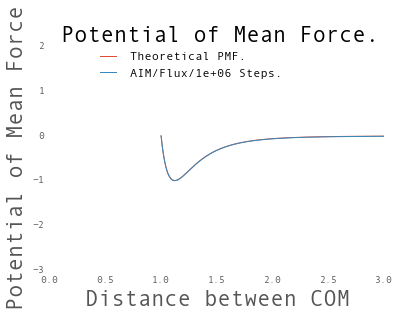

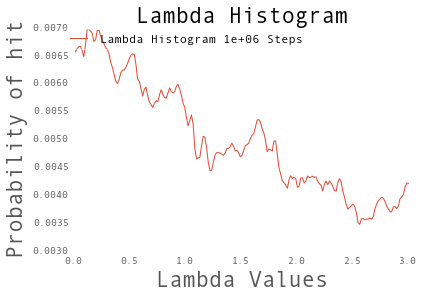

In [5]:
###############################################################################
# Plot the results
###############################################################################
# Calculate the boltzmann distribution over the range of r values
boltz = np.exp(-lj(l_values)*beta)
# Calculate the PMF of the boltzmann distribution
boltzpmf = np.zeros(binsize)
boltzpmf = -(1/beta)*np.log(boltz)

# Create arrays of x values to plot against
boltzrange = np.linspace(rng[0], rng[1], len(boltzpmf), endpoint=True)

i = 0
while i < (nbins - 1):
    i += 1
    myest = 0.5*(l_values[i]-l_values[i-1])*(dfest[i]+dfest[i-1])
    dfpmf[i] = dfpmf[i-1]+myest

plt.figure(1)
plt.title('Potential of Mean Force.'.format(L), fontsize=22)
plt.xlabel('Distance between COM', fontsize=22)
plt.ylabel('Potential of Mean Force', fontsize=22)
plt.plot(boltzrange, boltzpmf, label="Theoretical PMF.")
plt.plot(np.linspace(rng[0], rng[1], nbins), dfpmf, label="AIM/Flux/{0:1.0e} Steps." .format(nSteps))
plt.legend(bbox_to_anchor=(0.7, 1), loc=1, borderaxespad=0)

plt.xlim(0.0, rc)
plt.ylim(-3.0, 2.0)
plt.savefig("figure1.png")

dfnum = dfnum/sum(dfnum)
plt.figure(2)
plt.title("Lambda Histogram", fontsize=22)
plt.grid(True)
plt.xlabel("Lambda Values", fontsize=22)
plt.ylabel("Probability of hit", fontsize=22)
plt.plot(np.linspace(0, rc, len(dfnum)), dfnum, label="Lambda Histogram {0:1.0e} Steps" .format(nSteps))
plt.legend(bbox_to_anchor=(0.7, 1), loc=1, borderaxespad=0.1)
plt.savefig("figure2.png")

# Print out some results
#print ("Acceptance rate: ", (100.0*acc/float(nSteps)), "percent")
#print ("Lambda Acceptance rate: ", (100.0*l_accept/float(nSteps)), "percent")

###############################################################################
# Is it flat enough?  Is the minimum entry less that 80% of its average value?
# It is common practice to considr a histogram "sufficiently flat" when its
# minimum entry is no less than 80% of its average value.
###############################################################################

flatness = 100*(min(dfnum)/np.average(dfnum))
if flatness > 80:
    print ("It's flat enough")

print ("Boltzman PMF: ", np.trapz(boltzpmf))
print ("AIM PMF: ", np.trapz(dfpmf))